# Walkthrough for S3-helper function
<p>
    Forget where you put some sensitive information on your cloud database?
    <br>Tired of downloading files from s3 only to preview them in excel, or textpad?
    <br>Want to touch and reshape data but feel it's caged off from you?
    <br>Look no further, your s3 problems are solved!
</p>

## Table of Contents <a id='top'></a>
<header>
    This Jupyter notebook gives a walkthrough of several handy functions from the <a href='https://github.com/yinleon/s3'>s3 module</a>.
<br>With best intentions, these functions mirror the use of standard libraries, while empolying the backend of popular open source projects.
<br><br>The notebook highlights 7 functions:
</header>

1. List files (with wildcard) in a s3 bucket/key using <a href='#look'>ls()</a>
2. Read files into a string or bytes using <a href='#read'>read() and open()</a> 
3. Read csv and json files on s3 into Pandas dataframes using <a href='#read_csv'>read_csv() and read_json()</a>
4. Write csv and json files from Pandas dataframes to s3 using <a href='#write_csv'>to_csv() and to_json()</a>
5. Write local files to s3 using <a href='#write'>write()</a>
6. Saving and Loading <a href="#clf">Scikit-Learn classifiers </a>
7. Moving files to new buckets and keys using <a href="#move">mv()</a>

The only requirements are setting AWS environment variables or setting up the AWS CLI, and installing the `requirements.txt` modules.

For this tutorial, we'll use the red wine quality dataset from <a href='https://archive.ics.uci.edu/ml/datasets/Wine+Quality'>UCI Center for Machine Learning and Intelligent Systems</a>.

In [1]:
import os
import s3

## Listing files in a S3 bucket and key using ls( )<a id='look'></a>
<p>
    s3.ls will list all the files and directories in a bucket/key akin to os.listdir()
    <br><a href="https://github.com/yinleon/s3/blob/master/funcs.py#L80">see the code</a>
</p>

In [2]:
s3_path = 's3://prod-datalytics/playground/'

It takes in a bucket or bucket, key pair.

In [3]:
s3.ls(s3_path)

['s3://prod-datalytics/playground/json_bourne.json',
 's3://prod-datalytics/playground/wine_is_fine.csv',
 's3://prod-datalytics/playground/wine_is_not_fine.tsv']

s3.ls also supports regex-like wildcard patterns exactly like glob.glob()

In [4]:
s3.ls(s3_path + '*.csv')

['s3://prod-datalytics/playground/wine_is_fine.csv']

With a programmatic method of getting s3 file paths, we can start doing some cools stuff.
<br><a href='#top'>top</a>

## Read files in s3 with open() <a id='read'></a>

<a href="https://github.com/yinleon/s3/blob/master/funcs.py#L129">see the code</a>

In [5]:
f = s3.ls(s3_path + '*.csv')[0]
f

's3://prod-datalytics/playground/wine_is_fine.csv'

we can open the file as a streaming body of bytes.

In [6]:
s3.open(f)

this is helpful sometimes, but typically we want to read a file like Python's native 
<br>&emsp;Open(filename, 'r') as f: 
<br>&emsp;&emsp; f.read()
<br>

In [7]:
s3.read(f, encoding='utf-8')[:200] # displays the first 200 characters.

'fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality\n7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5'

For more structured data, we can leverage Pandas' parsing engines...
<br><a href='#top'>top</a>

## Read S3 files to memory with read_csv( ) and read_json( ) <a id='read_csv'></a>

<p>
    s3.read_csv and read_json are identical to their Pandas' 
    <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html">ancestor and backbone.</a>
    <br>
    Using this handy function, you have data displayed in a nice tabular format:<br>
    <a href="https://github.com/yinleon/s3/blob/master/frame.py#L13">see the code</a>
</p>

In [8]:
df = s3.read_csv(f, sep=',')
df.head(3)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5

a csv is the most simple use case, we can handle alternative delimiters and json files too.

In [9]:
files = s3.ls(s3_path)
files

['s3://prod-datalytics/playground/json_bourne.json',
 's3://prod-datalytics/playground/wine_is_fine.csv',
 's3://prod-datalytics/playground/wine_is_not_fine.tsv']

here are tab-separated values (tsv).

In [10]:
print("We can read the {} tsv easily.".format(files[-1]))

df = s3.read_csv(files[-1], sep='\t')
df.tail(3)

We can read the s3://prod-datalytics/playground/wine_is_not_fine.tsv tsv easily.


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6

here's a json file

In [11]:
print("We can also read the {} file easily.".format(files[0]))

df = s3.read_json(files[0])
df.sample(3)

We can also read the s3://prod-datalytics/playground/json_bourne.json file easily.


alcohol  chlorides  citric acid  density  fixed acidity  \
1289     10.2      0.068         0.30  0.99914            7.0   
607      10.5      0.092         0.41  0.99820            8.8   
675      10.2      0.064         0.39  0.99840            9.3   

      free sulfur dioxide    pH  quality  residual sugar  sulphates  \
1289                 20.0  3.30        5             4.5       1.17   
607                  26.0  3.31        6             3.3       0.53   
675                  12.0  3.26        5             2.2       0.65   

      total sulfur dioxide  volatile acidity  
1289                 110.0              0.60  
607                   52.0              0.48  
675                   31.0              0.41

they're actually all the same file-- in different formats!<br>
If you're new to Pandas, you'll be happy to learn that it is the de-facto tool for data manipulation.<br>

In [12]:
df.dtypes

alcohol                 float64
chlorides               float64
citric acid             float64
density                 float64
fixed acidity           float64
free sulfur dioxide     float64
pH                      float64
quality                   int64
residual sugar          float64
sulphates               float64
total sulfur dioxide    float64
volatile acidity        float64
dtype: object

Getting basic stats and distributions are a function away..

In [13]:
df.describe().T

count       mean        std      min      25%  \
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
pH                    1599.0   3.311113   0.154386  2.74000   3.2100   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   

                           50%        75%        max  
alcohol               10.20000  11.100000   14.90000  
chlorides              0.07900   0.090000    0.61100  
citric acid            0.26000   0.420000    1.00000  
density                0.99675   0.997835    1.00369  
fixed acidity          7.90000   9.200000   15.90000  
free sulfur dioxide   14.00000  21.000000   72.00000  
pH                     3.31000   3.400000    4.01000  
quality                6.00000   6.000000    8.00000  
residual sugar         2.20000   2.600000   15.50000  
sulphates              0.62000   0.730000    2.00000  
total sulfur dioxide  38.00000  62.000000  289.00000  
volatile acidity       0.52000   0.640000    1.58000

Everything is indexed!<br>
Here we get a quick calculation for the 75th percentile of alcohol content.

In [14]:
df.describe()['alcohol']['75%']

11.1

It's easy to filter a dataframe:<br> 
Here we're going to get all the heavily alcoholic wines...

In [15]:
df_alcoholic = df[df['alcohol'] > df.describe()['alcohol']['75%']]
df_alcoholic.head()

alcohol  chlorides  citric acid  density  fixed acidity  \
45      13.1      0.054         0.15   0.9934            4.6   
95      12.9      0.058         0.17   0.9932            4.7   
131     13.0      0.049         0.09   0.9937            5.6   
132     13.0      0.049         0.09   0.9937            5.6   
142     14.0      0.050         0.00   0.9916            5.2   

     free sulfur dioxide    pH  quality  residual sugar  sulphates  \
45                   8.0  3.90        4             2.1       0.56   
95                  17.0  3.85        6             2.3       0.60   
131                 17.0  3.63        5             2.3       0.63   
132                 17.0  3.63        5             2.3       0.63   
142                 27.0  3.68        6             1.8       0.79   

     total sulfur dioxide  volatile acidity  
45                   65.0              0.52  
95                  106.0              0.60  
131                  99.0              0.50  
132                  99.0              0.50  
142                  63.0              0.34

It's also stupid easy to plot-- as Pandas extends the Matplotlib package.

In [16]:
#this line is run once, typically at the beginning of the notebook to enable plotting.
%matplotlib inline

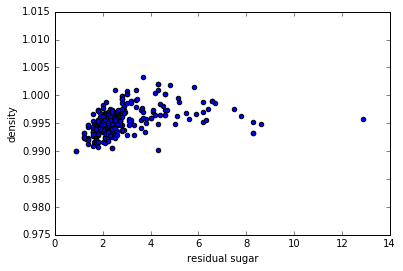

In [17]:
df_alcoholic.plot(kind='scatter', x='residual sugar', y='density')

What is that outlier?

In [2]:
df_alcoholic[df_alcoholic['residual sugar'] > 12]

After processing and normalizing the data, we may want to upload this new file to s3.
<br><a href='#top'>top</a>

## Write DataFrames to S3 with to_csv( ) and to_json( ) <a id='write_csv'></a>
<p>
    s3.read_csv and read_json are <i>almost</i> identical to their Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_csv.html">ancestor and backbone.</a>
    <br>The difference is that s3.to_csv takes the dataframe as an argument, rather than being a function of a dataframe.
    <br><a href="https://github.com/yinleon/s3/blob/master/frame.py#L57">see the code</a>
</p>

In [18]:
# where will the file get stored?
s3_target = 's3://prod-datalytics/playground/wine_list.tsv.gz'

We can now use our filtered dataset, to write a new file to s3.<br>
Using Pandas to_csv args, we have a lot of control of the output format.

In [19]:
s3.to_csv(df_alcoholic, s3_target, sep='\t',
          index=False, compression='gzip')

"File uploaded to 's3://prod-datalytics/playground/wine_list.tsv.gz'"

<a href='#top'>top</a>

## Write local files to S3 with disk_2_s3( ) <a id='write'></a> 
We can send local files to s3 too, first let's write a file to local disk using the built-in Pandas `to_csv()`.

In [20]:
local_file = 'wine_list.tsv.gz'

In [21]:
df_alcoholic.to_csv(local_file, sep='\t', index=False, compression='gzip')

In [22]:
s3.disk_2_s3(file=local_file,
             s3_path=s3_target)

"'wine_list.tsv.gz' loaded to 's3://prod-datalytics/playground/wine_list.tsv.gz'"

In [23]:
# purge it!
os.remove(local_file)

## Saving and Loading Scikit-Learn Classifiers <a id='clf'></a>
If you're into machine learning, you're in luck!
<br><a href="https://github.com/yinleon/s3/blob/master/clf.py">see the code</a>

In [24]:
from sklearn.ensemble import RandomForestClassifier

for the example let's just use a vanilla Random Forest Model

In [25]:
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Here is where we'd train and evaluate the model...

In [30]:
# fit the model!
# clf.fit(X, y)

ACCURACY ON TRAINING SET: 0.99
ACCURACY OF TEST SET: 0.61


My first run (not shown) I got a an test set accuracy of only 61%, which is pretty bad.<br>
You should try to beat that score!

In [ ]:
'''
write some code here:
look into train_test_split, gridsearchCV, and kfolds from Scikit-Learn.

This is also a great dataset to practice:
scaling values (see standardScaler)
dimensionality reduction (see PCA)
and a linear model (see Lasso or Logistic Regression)
'''

Once you're happy with the performance, we can persist the model as a pickle file.

In [31]:
s3.dump_clf(clf, 's3://prod-datalytics/playground/models/clf.pkl')

"'clf.pkl' loaded to 's3://prod-datalytics/playground/models/clf.pkl'"

And re-use it when the time is right!

In [32]:
s3.load_clf('s3://prod-datalytics/playground/models/clf.pkl')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<a href='#top'>top</a>

## Movin' Files between buckets and keys <a id='move'></a>
In the interest of good file-keeping let's move our saved classifier to it's own special folder (key).<br>

In [33]:
s3.cp(old_path='s3://prod-datalytics/playground/models/clf.pkl',
      new_path='s3://prod-datalytics/production_space/models/clf.pkl',)

{'CopyObjectResult': {'ETag': '"fd28ec0656661ce2a86373b097a95b89"',
  'LastModified': datetime.datetime(2017, 3, 2, 0, 13, 43, tzinfo=tzutc())},
 'CopySourceVersionId': 'ov3ei3i4mEGFOcBMEmi2g8atvAbVHKJx',
 'ResponseMetadata': {'HTTPStatusCode': 200,
  'HostId': 'ax6Q2HTAn+86P6wz6v2MWX3ZLsYoksdpqgcJtyKaXcEur80A4awZMiEEDuMLzzcydYNoyX3wBGQ=',
  'RequestId': 'AE98FD0B9CE85D9F'},
 'VersionId': 'OJX.ffdLzhrSD5kYc3wyMAWhtSWBIawN'}

to move the file (and delete the old instance) we use `mv`, instead of `cp`.

In [34]:
s3.mv(old_path='s3://prod-datalytics/playground/models/clf.pkl',
      new_path='s3://prod-datalytics/production_space/models/clf.pkl',)

{'DeleteMarker': True,
 'ResponseMetadata': {'HTTPStatusCode': 204,
  'HostId': 'wevPToOM9kIl8QId3r9NzheWcq5c1Rw43kUnH9Js7Ja8N3Ah/8G5DxzfKO9JVaL4uZ8RMkSkN5o=',
  'RequestId': '9E3FC788589304B4'},
 'VersionId': 'tnPVq8F1usk.sBxewcQ2SUWaYOrG3KXN'}

<a href='#top'>top</a>